# EM-based method for OT-based registration (linear)

## Description

### General approach

This version of OT registration formulates the problem of image registration as a latent variable model, and proposes an iterative, EM-based approach to inferring the spatial mapping between the two images from the data. This approach (model, EM derivation, use of OT for E-step) was suggested by Prof. Scott Linderman as a potential improvement on our earlier OT regression method. The earlier method is equivalent to a single iteration of this method.

### Model

Let $x_{1,i}, x_{2,i} \in \mathbb{R}^D$ denote the locations of neuron $i$ in two successive frames. The objective is to find a parameteric transformation $f(x; \theta)$ that maps points in frame 1 to points in frame 2. If the correspondence between these points was known, this would be a simple regression problem. Instead, we have a set of observed points in both frames but the labels are permuted. We can treat this as a latent variable problem with a hidden permutation:
$$
\begin{align*}
    p(x_2, \pi \mid x_1, \theta)
        &= p(\pi) \, p(x_2 \mid \pi, x_1, \theta) \\
        &= p(\pi) \, \prod_{i=1}^N \mathcal{N}(x_{2, \pi(i)} \mid f(x_{1, i}; \theta), \, \sigma^2 I).
\end{align*}
$$

### Estimating parameters with expectation maximization (EM)

We can treat this like any other latent variable problem and solve for the optimal parameters $\theta$ via expectation-maximization, using optimal transport to approximate the expectation in the E-step. This can be most easily explained by deriving the M-step first.

#### M-step 

For the sake of argument, let $q(\pi|\theta^{(k)})$ denote the posterior distribution over permutations given the current estimate $\theta^{(k)}$ of the parameters. The M-step updates the parameters to:
$$
\begin{align*}
    \theta^{(k+1)} &\leftarrow \underset{\theta}{\mathrm{argmax\ }} \; \mathbf{E}_{q(\pi|\theta^{(k)})} \big[ \log p(x_2, \pi \mid x_1, \theta) \big] \\
        &= \underset{\theta}{\mathrm{argmax\ }} \; \mathbf{E}_{q(\pi|\theta^{(k)})} \big[ \log \big[ p(\pi) \, \prod_{i=1}^N \mathcal{N}(x_{2, \pi(i)} \mid f(x_{1, i}; \theta), \, \sigma^2 I)\big] \big] \\
        &= \underset{\theta}{\mathrm{argmax\ }} \; \mathbf{E}_{q(\pi|\theta^{(k)})} \big[ \log \, p(\pi) - \sum_{i=1}^N \frac{1}{2\sigma^2} \|x_{2, \pi(i)} - f(x_{1, i}; \theta) \|_2^2 \big] \\ 
        &= \underset{\theta}{\mathrm{argmax\ }} \; \mathbf{E}_{q(\pi|\theta^{(k)})} \big[ \log \, p(\pi) \big] - \mathbf{E}_{q(\pi|\theta^{(k)})} \big[ \sum_{i=1}^N \frac{1}{2\sigma^2} \|x_{2, \pi(i)} - f(x_{1, i}; \theta) \|_2^2 \big] \\ 
\end{align*}
$$
Because $\mathbf{E}_{q(\pi|\theta^{(k)})} \big[ \log \, p(\pi) \big]$ doesn't depend on $\theta$, we have:
$$
\begin{align*}
        &= \underset{\theta}{\mathrm{argmin\ }} \; 
            \mathbf{E}_{q(\pi|\theta^{(k)})} \big[
            \sum_{i=1}^N \frac{1}{2\sigma^2} \|x_{2, \pi(i)} - f(x_{1, i}; \theta) \|_2^2 \big] \\ 
        &= \underset{\theta}{\mathrm{argmin\ }} \; 
            \frac{1}{2\sigma^2} \sum_{i=1}^N \mathbf{E}_{q(\pi|\theta^{(k)})} \big[
            \|x_{2, \pi(i)} - f(x_{1, i}; \theta) \|_2^2 \big] \\ 
         &= \underset{\theta}{\mathrm{argmin\ }} \; 
            \sum_{i=1}^N \mathbf{E}_{q(\pi|\theta^{(k)})} \big[
            \|x_{2, \pi(i)} - f(x_{1, i}; \theta) \|_2^2 \big] \\ 
\end{align*}
$$
Using linearity of expectation and an indicator function, we can write this as two sums:
$$
\begin{align*}
        &= \underset{\theta}{\mathrm{argmin\ }} \; 
            \sum_{i=1}^N \mathbf{E}_{q(\pi|\theta^{(k)})} \big[ 
            \sum_{j=1}^N \mathbf{I}[\pi(i) = j] 
            \cdot \|x_{2, j} - f(x_{1, i}; \theta)\|_2^2 \big] \\ 
        &= \underset{\theta}{\mathrm{argmin\ }} \; 
            \sum_{i=1}^N  \sum_{j=1}^N 
            \mathbf{E}_{q(\pi|\theta^{(k)})} \big[\mathbf{I}[\pi(i) = j] \big]
            \cdot \|x_{2, j} - f(x_{1, i}; \theta)\|_2^2  \\ 
\end{align*}
$$
This is just a weighted least squares regression problem, where $\mathbf{E}_{q(\pi|\theta^{(k)})} \big[\mathbf{I}[\pi(i) = j] \big]$ is the weight for the data point $(x_{1,i}, x_{2,j})$. For the E-step, all we need to do is to estimate this expectation.

#### E-step

To estimate the expectation $\mathbf{E}_{q(\pi|\theta^{(k)})} \big[\mathbf{I}[\pi(i) = j] \big]$, we will solve the optimal transport problem between the transformed points $f(x_1; \theta^{(k)})$ and $x_2$, using the matching pursuit weights $w_1$ and $w_2$
$$
\begin{align*}
 P^* &= \underset{P}{\text{argmin }} <M, P> \\
     &\text{s.t.} \quad  P \mathbf{1} = w_1, \, P^{T} \mathbf{1} = w_2,\, P_{ij} > 0 \, \forall i,j
\end{align*}
$$
where $M$ is the distance matrix between $f(x_1; \theta^{(k)})$ and $x_2$. We use the transportation matrix $P^*$ to approximate the expectation:
$$
\begin{equation*}
    \mathbf{E}_{q(\pi | \theta^{(k)})}\big[\mathbf{I}[\pi(i)=j]\big] \approx P^*_{ij}
\end{equation*}
$$

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
from sklearn.linear_model import LinearRegression

from otimage import imagerep, io
from otimage.utils import plot_maxproj

## Implement OT registration

In [3]:
def _compute_ot(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    M_nn = ot.dist(pts_1, pts_2, metric='sqeuclidean')
    M = M_nn / np.median(M_nn)
    
    # Compute transport plan
    return ot.emd(p_1, p_2, M, log=True)
    

def _ot_reg(pts_1, pts_2, p_mtx):
    """Compute weighted linear regression using OT plan"""
    
    # Get pairs of points with values above threshold, and corresponding weights from P matrix
    idx_1, idx_2 = np.nonzero(p_mtx)
    x = pts_1[idx_1]
    y = pts_2[idx_2]
    smp_wt = p_mtx[idx_1, idx_2]

    # Use sklearn.linear_model.LinearRegression to minimize cost function
    model = LinearRegression(fit_intercept=True)
    model.fit(x, y, sample_weight=smp_wt)

    # Estimates of transform parameters
    alpha = model.intercept_
    beta = model.coef_
    
    return alpha, beta


def ot_reg_linear(mp_1, mp_2, n_iter):
    """EM-based OT registration method with linear model."""
    
    alpha = [np.zeros(3)] + [None] * n_iter
    beta = [np.eye(3)] + [None] * n_iter
    
    pts = [None] * n_iter
    p_mtx = [None] * n_iter
    ot_log = [None] * n_iter
    
    for i in range(n_iter):
        
        # E-step: Compute OT between current points and target points
        pts[i] = alpha[i] + mp_1.pts @ beta[i].T
        p_mtx[i], ot_log[i] = _compute_ot(pts[i], mp_2.pts, mp_1.wts, mp_2.wts)
        
        # M-step: Compute new mapping using transport plan
        alpha[i + 1], beta[i + 1] =  _ot_reg(mp_1.pts, mp_2.pts, p_mtx[i])
       
    debug = {
        'alpha': alpha,
        'beta': beta,
        'pf_pts': pts,
        'p_mtx': p_mtx,
        'ot_log': ot_log,
    }
    
    return alpha[-1], beta[-1], debug

## Load data

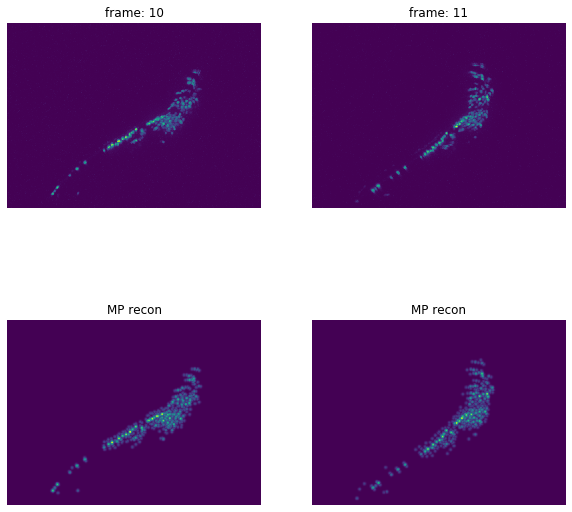

In [9]:
# Frame index
t1 = 10
t2 = t1 + 1

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mp_1 = reader.get_frame(t1)
    mp_2 = reader.get_frame(t2)

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_mp_image(mp_1, units)
rec_2 = imagerep.reconstruct_mp_image(mp_2, units)

plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Run OT registration on images 

In [10]:
n_iter = 50

alpha, beta, debug = ot_reg_linear(mp_1, mp_2, n_iter)

print('alpha (est):')
print(alpha)
print('beta (est):')
print(beta)

alpha (est):
[ 28.97499413 -28.1325161   -0.6935389 ]
beta (est):
[[ 1.01934915 -0.34611226  0.03250356]
 [ 0.20562821  0.92059821  0.12879351]
 [ 0.01312254 -0.01018046  0.972199  ]]


## Reconstruct second frame using mapping

### MP space

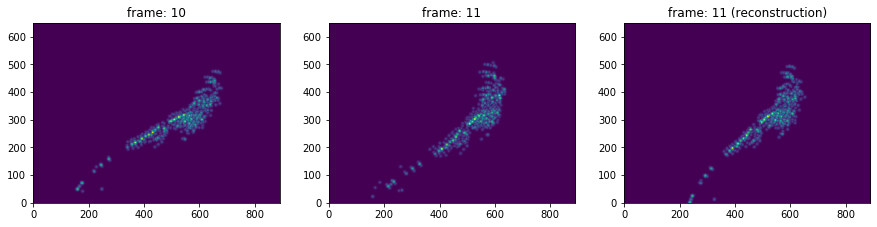

In [11]:
# Transform MP points for first image using mapping
pf_pts = mp_1.pts @ beta.T + alpha

# Reconstruct image from transformed points
mp_pf = imagerep.ImageMP(pf_pts, mp_1.wts, mp_1.cov, mp_1.img_limits)
rec_pf = imagerep.reconstruct_mp_image(mp_pf, units)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(rec_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(rec_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(rec_pf)
plt.title(f'frame: {t2} (reconstruction)');

### Pixel space

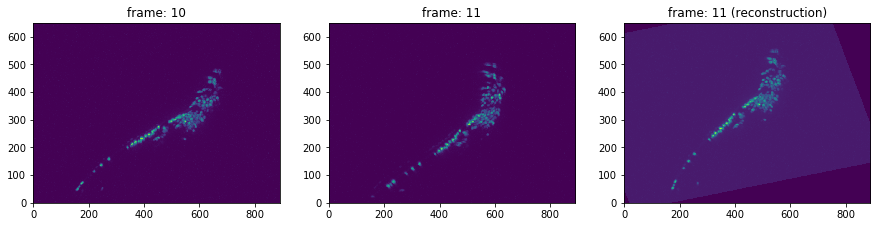

In [12]:
# Transform first image using mapping
inv_beta = np.linalg.inv(beta)
inv_alpha = -inv_beta @ alpha
map_img = affine_transform(img_1, inv_beta, inv_alpha)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(map_img)
plt.title(f'frame: {t2} (reconstruction)');

## Changes in mapping over iterations

### Coordinates of single MP point

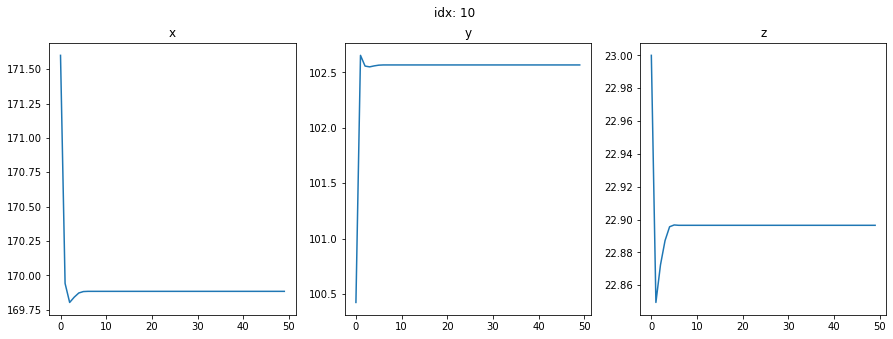

In [13]:
idx = 10

x_vals = [p[idx, 0] for p in debug['pf_pts']]
y_vals = [p[idx, 1] for p in debug['pf_pts']]
z_vals = [p[idx, 2] for p in debug['pf_pts']]

plt.figure(figsize=(15, 5))
plt.suptitle(f'idx: {idx}')

plt.subplot(131)
plt.plot(x_vals)
plt.title('x')

plt.subplot(132)
plt.plot(y_vals)
plt.title('y')

plt.subplot(133)
plt.plot(z_vals);
plt.title('z');

### MP reconstruction of entire image

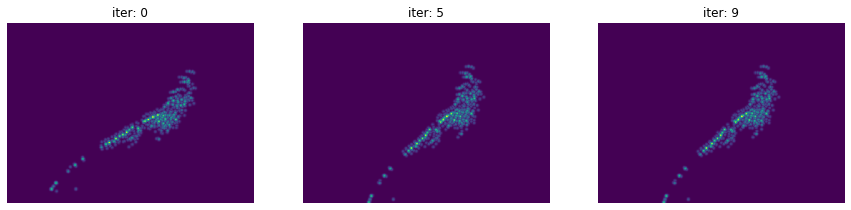

In [15]:
iters = [0, 5, 9]

trans_mps = [imagerep.ImageMP(debug['pf_pts'][i], mp_1.wts, mp_1.cov, mp_1.img_limits) for i in iters]
trans_rec = [imagerep.reconstruct_mp_image(mp, units) for mp in trans_mps]

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(trans_rec[0])
plt.title(f'iter: {iters[0]}')
plt.axis('off')
        
plt.subplot(132)
plot_maxproj(trans_rec[1])
plt.title(f'iter: {iters[1]}')
plt.axis('off')
        
plt.subplot(133)
plot_maxproj(trans_rec[2])
plt.title(f'iter: {iters[2]}')
plt.axis('off');